# Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-b5356651-0d8e-5cd1-bdf3-ccbb8b221031"

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
# from tensorflow.keras import layers
import numpy as np
from numpy.random import default_rng
import scipy.linalg as la
from scipy.special import gammaln
import scipy.cluster.vq as vq
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import netCDF4 as nc
import re
import pandas as pd
import sklearn as skl
import seaborn as sns
from tqdm.auto import tqdm
import tuning_fun as tu
import emulator_fun as ef
import time
from scipy.stats import boxcox, gaussian_kde

2025-07-11 01:11:32.325431: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 01:11:32.339507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752210692.352845 3908518 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752210692.356899 3908518 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-11 01:11:32.373800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# allocating GPU memory

gpus = tf.config.list_physical_devices('GPU')

# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_virtual_device_configuration(
#             gpu,
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
#         )
#             # tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# model

## read files

In [3]:
case_name = 'box_coal_qn_4map_hill_growth_dt1_momrates_target_BOSS_N2000_dt1'
base_path = 'summary_ncs/'
# base_path = '/Users/arthurhu/github/BOSS_PPE/summary_ncs/'
# base_path = '/pscratch/sd/a/arthurhu/BOSS_PPE/summary_ncs/'
filename = case_name + '.nc'

param_all_idx = np.arange(38)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
param_interest_idx = np.arange(16,28)
# param_interest_idx = np.arange(28,39)
# param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))
param_not_int_idx = [i for i in param_all_idx if i not in param_interest_idx]

param_train = ef.get_params(base_path, filename, param_interest_idx)

nppe, npar = param_train['vals'].shape

n_input = param_train['vals'].shape[1]


In [4]:
model_name = 'multioutput_box_coal_qn_4map_hill_growth_dt1_momrates_target_BOSS_standard_scaler_asinh'
cc_model = tf.keras.models.load_model('models/' + model_name + '.keras', compile=False)

orig_param_csv = '/home/arthurhu/Cloud_BOSS/param_consolid_simPL_coal3046_4map_hill_growth'
param_table = pd.read_csv(orig_param_csv + '.csv')
param_names = param_table.columns[1+param_interest_idx].to_list()

param_mean = param_table.values[0, 1+param_interest_idx].astype(np.float32)
param_std = param_table.values[1, 1+param_interest_idx].astype(np.float32)
nparam = len(param_names)

param_mean, param_names

I0000 00:00:1752210703.257967 3908518 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21789 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:e1:00.0, compute capability: 8.0


(array([-81.95419   ,   1.2192588 ,   2.2150013 ,  -2.693068  ,
          2.7824693 ,  -2.21642   ,  -1.2057952 ,  -2.1012905 ,
          1.1920915 ,  -0.6814475 ,   1.391271  ,   0.40530458],
       dtype=float32),
 ['a0coal_db',
  'bmcoal',
  'bncoal',
  'bx0coal',
  'bxscoal',
  'bxxcoal',
  'bxycoal',
  'by0coal',
  'byscoal',
  'byxcoal',
  'byycoal',
  'mtrans0_db'])

In [5]:
dataset = nc.Dataset(base_path + filename, mode='r')
n_init = getattr(dataset, 'n_init')
eff0s = getattr(dataset, 'thresholds_eff0')
var_constraints = getattr(dataset, 'var_constraints')
ppe_var_names = ['boss_' + i for i in var_constraints]
ppe_raw_vals = [dataset.variables[i][:] for i in ppe_var_names]
tgt_var_names = ['bin_' + i for i in var_constraints]
tgt_raw_vals = [dataset.variables[i][:] for i in tgt_var_names]

In [6]:
n_tgt_ics = tgt_raw_vals[0].shape[0]
npar = n_input - n_init
nobs = int(sum([ppe_raw_vals[i].size for i in range(len(var_constraints))])/nppe)

In [7]:
init_vars = getattr(dataset, 'init_var')
if isinstance(init_vars, str):
    init_vars = [init_vars]

initvar_matrix = []

for i_init, init_var in enumerate(init_vars):
    initvar_matrix.append(np.expand_dims(dataset.variables['case_' + init_var][:], axis=1))

tgt_sim_ics = np.concatenate(initvar_matrix, axis=1)
ncases = tgt_raw_vals[0].shape[0]
nvar = len(var_constraints)

In [8]:
from sklearn import preprocessing

ppe_var_presence = []
ppe_norm = []
ppe_data = []
tgt_var_presence = []
tgt_norm = []
tgt_data = []
standard_scales = []
minmaxscales = []
lams = np.zeros([nppe, nvar])
mean_lams = []
mean_lams = [0.055498322802165934, 0.0933773790989478, 0.06646735726712215]

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])

dmin = 0.
dmax = 9.2
drange = dmax - dmin
transform_method = 'standard_scaler_asinh'
# transform_method = 'standard_scaler_asinh'
# transform_method = 'meanboxcox'
# transform_method = 'standard_scaler'

for ivar, eff0 in enumerate(eff0s):
    cloud_filter = None

    # WARNING: only use this filter when advection is off
    cloud_filter = ppe_raw_vals[ivar][0]>0.
    n_cloud = np.sum(cloud_filter)
        
    if cloud_filter is not None:
        ppe_raw_val_reshaped = ppe_raw_vals[ivar][:, cloud_filter].reshape(nppe, n_cloud)
        tgt_raw_val_reshaped = tgt_raw_vals[ivar][:, cloud_filter].reshape(ncases, n_cloud)
        ppe_raw_val_reshaped[ppe_raw_val_reshaped<0] = 0.
        tgt_raw_val_reshaped[tgt_raw_val_reshaped<0] = 0.
    else:
        if ppe_raw_vals[ivar].ndim >= 2:
            ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[ivar], (nppe, np.prod(ppe_raw_vals[ivar].shape[1:])))
            tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[ivar], (ncases, np.prod(tgt_raw_vals[ivar].shape[1:])))
            # WARNING: temporary limiter
            ppe_raw_val_reshaped[ppe_raw_val_reshaped<0] = 0.
            tgt_raw_val_reshaped[tgt_raw_val_reshaped<0] = 0.
        else:
            ppe_raw_val_reshaped = ppe_raw_vals[ivar].reshape(-1, 1)
            tgt_raw_val_reshaped = tgt_raw_vals[ivar].reshape(-1, 1)

    ppe_var_presence.append(ppe_raw_val_reshaped > eff0/100)
    tgt_var_presence.append(tgt_raw_val_reshaped > eff0/100)

    # if transform_method == 'meanboxcox':
    #     for ippe in tqdm(range(nppe), desc='Box-Cox transform for ' + var_constraints[ivar]):
    #         lams[ippe, ivar] = boxcox(ppe_raw_val_reshaped[ippe,::10])[1]
    #     mean_lams.append(np.mean(lams[:, ivar]))

    
    if 'V_M' in var_constraints[ivar]:
        mmscale = preprocessing.MinMaxScaler().fit(ppe_raw_val_reshaped)
        # manually set all minmaxscale to the same range
        mmscale.data_min_[:] = dmin
        mmscale.data_max_[:] = dmax
        mmscale.data_range_[:] = drange
        mmscale.scale_[:] = 1/drange
        minmaxscales.append(mmscale)
        ppe_data.append(mmscale.transform(ppe_raw_val_reshaped))
        tgt_data.append(mmscale.transform(tgt_raw_val_reshaped))
    else:
        if transform_method == 'meanboxcox':
            ppe_norm.append(ef.boxcox(ppe_raw_val_reshaped, mean_lams[ivar]))
            tgt_norm.append(ef.boxcox(tgt_raw_val_reshaped, mean_lams[ivar]))
            standscale = preprocessing.StandardScaler().fit(ppe_norm[-1])
            standard_scales.append(standscale)
        elif transform_method == 'standard_scaler':
            ppe_norm.append(ppe_raw_val_reshaped)
            tgt_norm.append(tgt_raw_val_reshaped)
            standscale = preprocessing.StandardScaler().fit(ppe_raw_val_reshaped)
            standard_scales.append(standscale)
        elif transform_method == 'standard_scaler_asinh':
            ppe_norm.append(ef.smooth_linlog(ppe_raw_val_reshaped, eff0))
            tgt_norm.append(ef.smooth_linlog(tgt_raw_val_reshaped, eff0))
            standscale = preprocessing.StandardScaler().fit(ppe_norm[-1])
            standard_scales.append(standscale)
        elif transform_method == 'minmaxscale_asinh':
            ppe_norm.append(ef.smooth_linlog(ppe_raw_val_reshaped, eff0))
            tgt_norm.append(ef.smooth_linlog(tgt_raw_val_reshaped, eff0))
            mmscale = preprocessing.MinMaxScaler().fit(ppe_norm[-1])
            mmscale.data_min_[:] = min(mmscale.data_min_)
            mmscale.data_max_[:] = max(mmscale.data_max_)
            mmscale.data_range_[:] = max(mmscale.data_max_) - min(mmscale.data_min_)
            mmscale.scale_ = 1/mmscale.data_range_
            minmaxscales.append(mmscale)

mom_consistency_mask = np.min(np.array(ppe_var_presence), axis=0)
scale_mask = np.max(mom_consistency_mask, axis=0)

for i, iscale in enumerate(minmaxscales):
    iscale.scale_ = iscale.scale_ * scale_mask
    dat = iscale.transform(ppe_norm[i])
    dat[np.isinf(dat)] = np.nan
    ppe_data.append(dat)
    dat = iscale.transform(tgt_norm[i])
    dat[np.isinf(dat)] = np.nan
    tgt_data.append(dat)


for i, iscale in enumerate(standard_scales):
    iscale.scale_ = iscale.scale_ * scale_mask
    dat = iscale.transform(ppe_norm[i])
    dat[np.isinf(dat)] = np.nan
    ppe_data.append(dat)
    dat = iscale.transform(tgt_norm[i])
    dat[np.isinf(dat)] = np.nan
    tgt_data.append(dat)

In [9]:
import sklearn.model_selection as mod_sec
y_train_wpresence = []
y_train_rawv = []
y_val_wpresence = []
y_val_rawv = []

x_train, x_val, _, _ = mod_sec.train_test_split(x_all, ppe_var_presence[0], test_size=0.2, random_state=1)

for ivar, (ppe_varp, ppe_varr) in enumerate(zip(ppe_var_presence, ppe_data)):
    _, _, y_train_wpresence_single, y_val_wpresence_single = mod_sec.train_test_split(x_all, ppe_varp, test_size=0.2, random_state=1)
    _, _, y_train_rawv_single, y_val_rawv_single = mod_sec.train_test_split(x_all, ppe_varr, test_size=0.2, random_state=1)
    y_train_wpresence.append(y_train_wpresence_single)
    y_train_rawv.append(np.nan_to_num(y_train_rawv_single, nan=-1001, neginf=-1001, posinf=-1001))
    y_val_wpresence.append(y_val_wpresence_single)
    y_val_rawv.append(np.nan_to_num(y_val_rawv_single, nan=-1001, neginf=-1001, posinf=-1001))


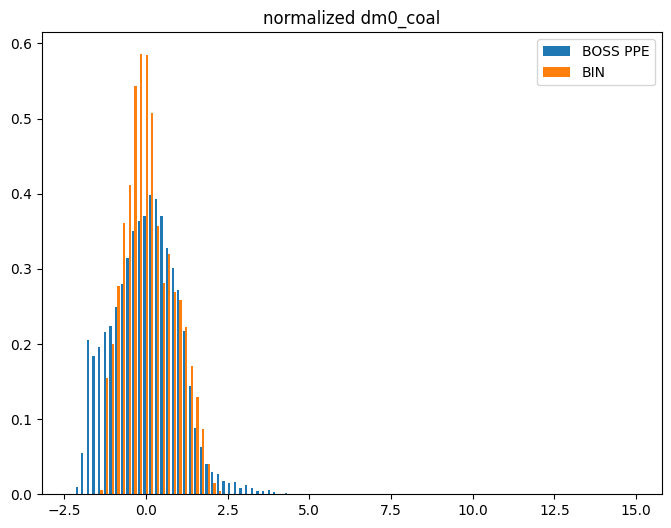

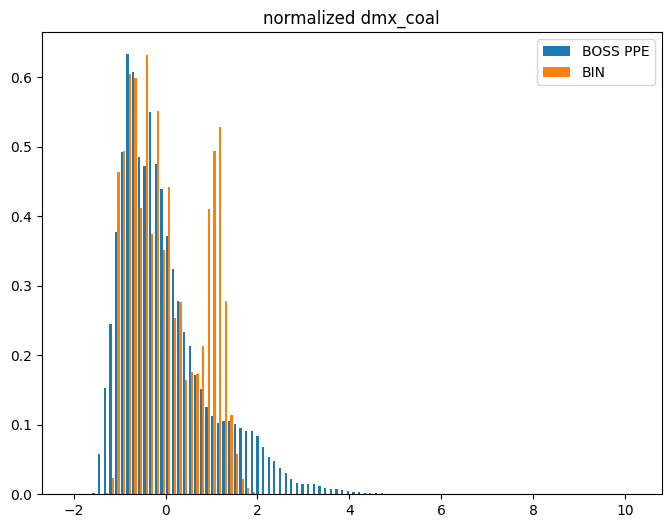

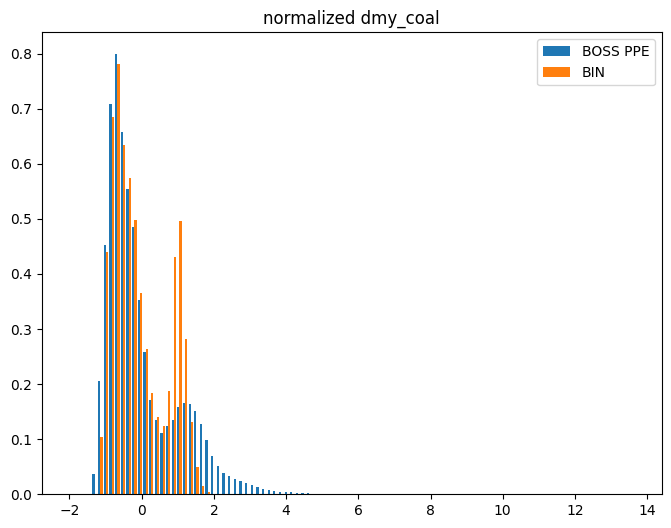

In [10]:
for i, eff0 in enumerate(eff0s):
    fig = plt.figure(figsize=(8, 6))
    _ = plt.hist([ppe_data[i].flatten(), tgt_data[i].flatten()],
                 bins=100,
                 density=True,
                #  range=(-8, 8),
                 label=['BOSS PPE', 'BIN'])
    plt.legend()
    plt.title('normalized ' + var_constraints[i])

## run

In [11]:
n_tgt_ics

72

In [12]:
tfd = tfp.distributions
tfb = tfp.bijectors

nchains = 8
# tf.keras.backend.set_floatx('float32')
IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = minmaxscale.transform(IC_with_dummy)[:,:n_init].astype('float32')
# valid_mask = tf.math.is_finite(tgt_data)
weights = np.ones([n_tgt_ics, nobs]).astype('float32')


In [13]:
params = tf.zeros(npar) + 0.5
params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
param_lp = tf.reduce_sum(tfd.Uniform(low=0.0,
                                     high=1.0).log_prob(params_2d))
input_norm = tf.concat([IC_norm, params_2d], axis=1) # n_tgt_ics x n_input
y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs
obs_lps = []

# for tgt_sngl, emu_sngl in zip(tgt_data, y_emu):
#     valid_mask = tf.math.is_finite(tgt_sngl)
#     tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
#     emu_valid = tf.boolean_mask(emu_sngl, valid_mask)
#     obs_lps.append(tf.reduce_mean(tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=1.).log_prob(tf.cast(emu_valid, tf.float32))))

for tgt_sngl, pres_sngl, water_sngl in zip(tgt_data, y_emu['presence'], y_emu['water']):
    # bins = 100  # or choose adaptively
    # hist, bin_edges = np.histogram(tgt_sngl.flatten(), bins=bins, density=True)
    # # Assign each point to a bin
    # indices = np.digitize(tgt_sngl.flatten(), bin_edges) - 1
    # indices = np.clip(indices, 0, len(hist) - 1)
    # densities = hist[indices]
    # # Clip indices to avoid out-of-bounds errors
    # densities = np.clip(densities, 1e-3, None)
    # weights_tgt = 1/densities

    valid_mask = tf.math.is_finite(tgt_sngl)
    tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
    pres_sngl = pres_sngl.numpy()
    pres_sngl[pres_sngl<0.1] = 0.
    emu_valid = tf.boolean_mask(pres_sngl * water_sngl, valid_mask)
    obs_lps.append(tf.reduce_mean(tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=1.).log_prob(tf.cast(emu_valid, tf.float32))))

# eps = 1e-7
# y_emu_wpresence = tf.cast(y_emu[0], tf.float32)
# y_emu_wpresence_clipped = tf.clip_by_value(y_emu_wpresence, eps, 1 - eps) # to avoid NaN in log likelihood
# # valid_mask_float = tf.cast(valid_mask, tf.float32)
# wpresence_lps = tfp.distributions.Bernoulli(probs=y_emu_wpresence_clipped).log_prob(valid_mask_float)
# wpresence_lp = tf.reduce_sum(wpresence_lps)

print(tf.reduce_sum(obs_lps))

tf.Tensor(-2.8426895, shape=(), dtype=float32)


### get log likelihood of obs so that it's not overpowered by log priors

In [14]:
param_lps = []
sigma_lps = []
obs_lps = []
# wpresence_lps = []
exp_rate = 1
# sigmas = []
obs_lps = []
bins=100

for i in tqdm(range(1000)):
    initial_state = tf.random.normal([npar+1])
    # initial_state = tf.concat([
    # tf.random.normal([npar]),
    # tf.random.normal([1],)], axis=-1)

    # initial_state = tf.zeros(npar, dtype='float32')
    params = initial_state[:-1]
    params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
    theta=tfb.Sigmoid().forward(params_2d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta))

    log_sigma = initial_state[-1]
    sigma = tf.exp(log_sigma)
    # sigma_lp = tfd.Uniform(low=0.1, high=5).log_prob(sigma)
    sigma_lp = tfd.Exponential(rate=exp_rate).log_prob(sigma) + log_sigma

    input_norm = tf.concat([IC_norm, theta], axis=1) # n_tgt_ics x n_input
    y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs

    obs_lp = []

    # for tgt_sngl, emu_sngl in zip(tgt_data, y_emu):
    #     valid_mask = tf.math.is_finite(tgt_sngl)
    #     tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
    #     emu_valid = tf.boolean_mask(emu_sngl, valid_mask)
    
    for tgt_sngl, pres_sngl, water_sngl in zip(tgt_data, y_emu['presence'], y_emu['water']):
        hist, bin_edges = np.histogram(tgt_sngl.flatten(), bins=bins, density=True)
        # Assign each point to a bin
        indices = np.digitize(tgt_sngl.flatten(), bin_edges) - 1
        indices = np.clip(indices, 0, len(hist) - 1)
        densities = hist[indices]
        # Clip indices to avoid out-of-bounds errors
        densities = np.clip(densities, 1e-3, None)
        weights_tgt = 1/densities

        valid_mask = tf.math.is_finite(tgt_sngl)
        tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
        pres_sngl = pres_sngl.numpy()
        pres_sngl[pres_sngl<0.1] = 0.
        emu_valid = tf.boolean_mask(pres_sngl * water_sngl, valid_mask)
        obs_lp.append(tf.reduce_mean(weights_tgt * tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=sigma).log_prob(tf.cast(emu_valid, tf.float32))))
    # for tgt_sngl, emu_sngl in zip(tgt_data, y_emu):
    #     valid_mask = tf.math.is_finite(tgt_sngl)
    #     tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
    #     emu_valid = tf.boolean_mask(emu_sngl, valid_mask)
    #     obs_lp.append(tf.reduce_mean(tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=sigma).log_prob(tf.cast(emu_valid, tf.float32))))
    param_lps.append(param_lp)
    obs_lps.append(tf.reduce_sum(obs_lp))
    # wpresence_lps.append(wpresence_lp)
    sigma_lps.append(sigma_lp)
    # sigmas.append(sigma)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
s_obs = np.std(param_lps)/np.std(obs_lps)
m_obs = np.mean(param_lps)/np.mean(obs_lps)
# s_wpr = np.std(param_lps)/np.std(wpresence_lps)
s_sig = np.std(param_lps)/np.std(sigma_lps)
m_sig = np.mean(param_lps)/np.mean(sigma_lps)
print(s_obs, m_obs, s_sig, m_sig, np.mean(param_lps), np.mean(obs_lps), np.mean(sigma_lps))
# obs_lps[:4]

0.3123413 22.251097 39.71433 920.23395 -1509.8114 -67.85335 -1.6406821


### actual run

In [ ]:
exp_rate = 1
m_obs = max(m_obs, 1.)
m_sig = max(m_sig, 1.)

def get_BOSSemu_lp(params_sigma):
    params = params_sigma[:-1]
    params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
    theta=tfb.Sigmoid().forward(params_2d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta))

    # set up sigma
    log_sigma = params_sigma[-1]
    sigma = tf.exp(log_sigma)
    # sig_lp = tfd.Uniform(low=0.1, high=5).log_prob(sigma)
    sig_lp = tfd.Exponential(rate=exp_rate).log_prob(sigma) + log_sigma

    # get normalized ICs
    input_norm = tf.concat([IC_norm, theta], axis=1) # n_tgt_ics x n_input
    y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs

    obs_lps = []
    # for tgt_sngl, emu_sngl in zip(tgt_data, y_emu):
    #     valid_mask = tf.math.is_finite(tgt_sngl)
    #     tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
    #     emu_valid = tf.boolean_mask(emu_sngl, valid_mask)
    for tgt_sngl, pres_sngl, water_sngl in zip(tgt_data, y_emu['presence'], y_emu['water']):
        hist, bin_edges = np.histogram(tgt_sngl.flatten(), bins=bins, density=True)
        # Assign each point to a bin
        indices = np.digitize(tgt_sngl.flatten(), bin_edges) - 1
        indices = np.clip(indices, 0, len(hist) - 1)
        densities = hist[indices]
        # Clip indices to avoid out-of-bounds errors
        densities = np.clip(densities, 1e-3, None)
        weights_tgt = 1/densities

        valid_mask = tf.math.is_finite(tgt_sngl)
        tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
        emu_valid = tf.boolean_mask(pres_sngl * water_sngl, valid_mask)
        obs_lps.append(tf.reduce_mean(weights_tgt * tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=sigma).log_prob(tf.cast(emu_valid, tf.float32))))
    # for tgt_sngl, emu_sngl in zip(tgt_data, y_emu):
    #     valid_mask = tf.math.is_finite(tgt_sngl)
    #     tgt_valid = tf.boolean_mask(tgt_sngl, valid_mask)
    #     emu_valid = tf.boolean_mask(emu_sngl, valid_mask)
    #     obs_lps.append(tf.reduce_mean(tfd.Normal(loc=tf.cast(tgt_valid, tf.float32), scale=sigma).log_prob(tf.cast(emu_valid, tf.float32))))
    obs_lp = tf.reduce_sum(obs_lps)
    return param_lp + m_obs * obs_lp + m_sig * sig_lp

batched_BOSSemu_lp = lambda params_batch: tf.vectorized_map(get_BOSSemu_lp, params_batch)

num_burnin_steps = 5000
num_samples = 10000
# initial_state = tf.random.normal([nchains, npar+1], seed=1)
initial_state = tf.concat([tf.random.normal([nchains, npar], seed=0),
                           tf.zeros([nchains, 1])], axis=1)

stepsize = 0.01

hmc = tfp.mcmc.HamiltonianMonteCarlo(batched_BOSSemu_lp, step_size=stepsize, num_leapfrog_steps=3)
adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=hmc,
    num_adaptation_steps=int(num_burnin_steps * 0.8))

start = time.time()

@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(num_results=num_samples,
        current_state=initial_state,   # or your initial_state
        kernel=adaptive_hmc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, kr: kr.inner_results.is_accepted,
        seed=1)

samples, accs = run_chain()

end = time.time()
print(end-start)

721.6515500545502


acceptance rate: [0.7491 0.7481 0.7464 0.7501 0.7366 0.7517 0.7451 0.7424]


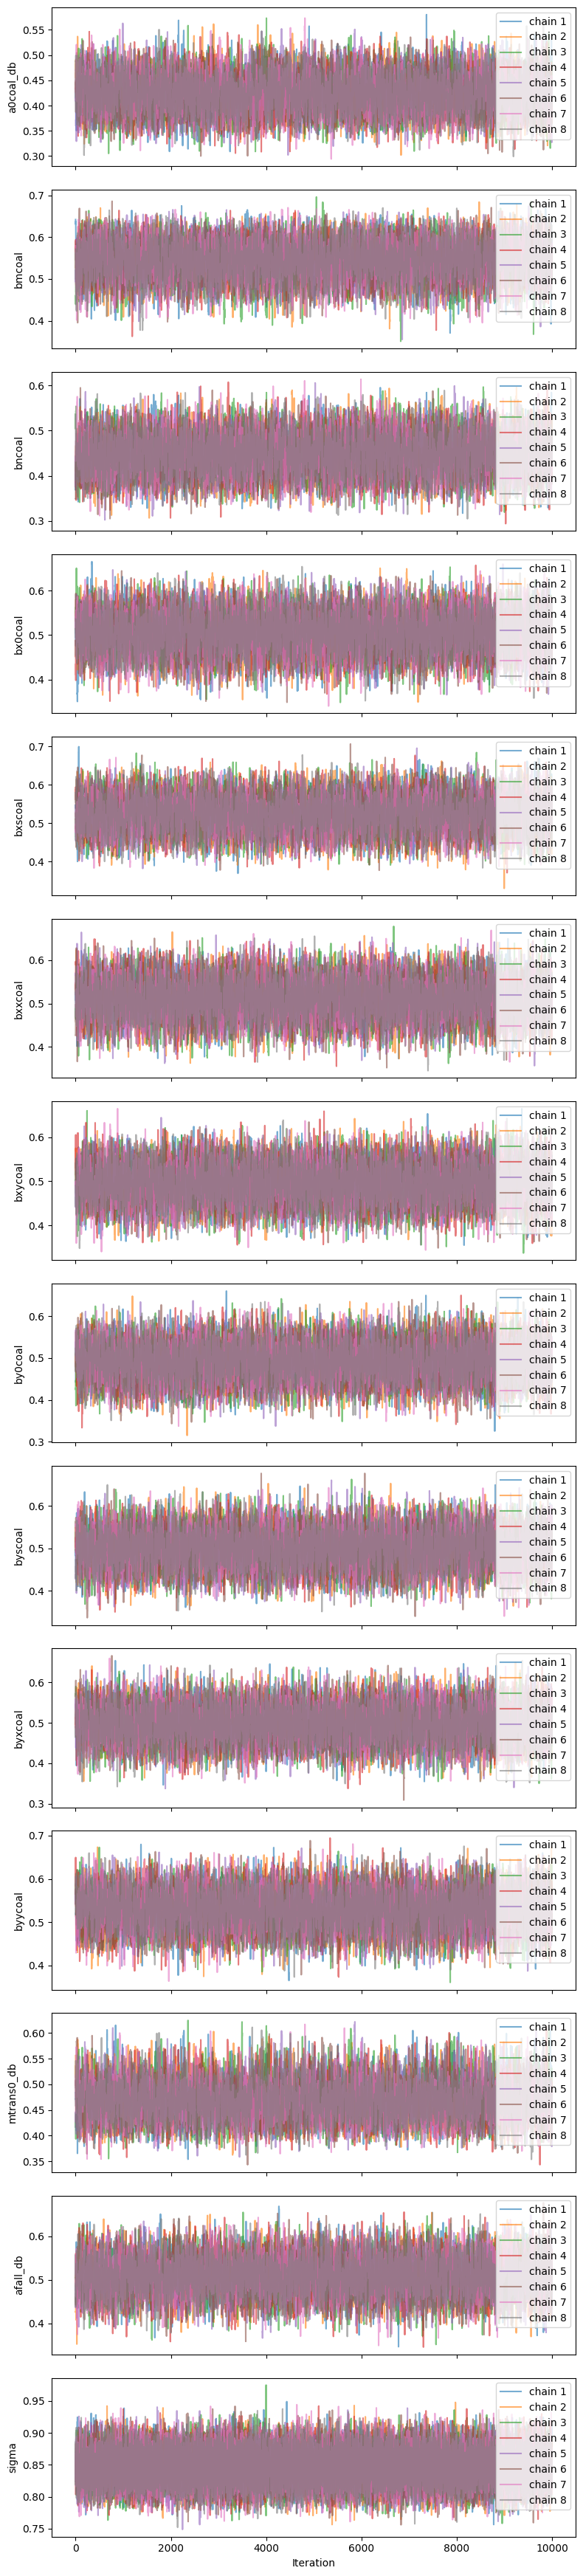

In [ ]:
# --- 4. Trace plots ---
def plot_traces(posterior, pnames):
    its, chains, dims = posterior.shape
    fig, axes = plt.subplots(dims, 1, figsize=(8, 2.5*dims), sharex=True)
    for d in range(dims):
        for c in range(chains):
            axes[d].plot(posterior[:,c,d], alpha=0.6, label=f'chain {c+1}')
        axes[d].set_ylabel(pnames[d])
        axes[d].legend(loc='upper right')
    axes[-1].set_xlabel('Iteration')
    plt.tight_layout()
    plt.show()

print("acceptance rate:", sum(accs.numpy())/num_samples)

# try:
#     print("acceptance rate:", sum(kr.is_accepted.numpy())/num_samples)
# except AttributeError:
#     print("acceptance rate:", sum(kr.inner_results.is_accepted.numpy())/num_samples)

param_names_incl_sigma = param_names + ['sigma']
transformed_samples = tf.concat([tfb.Sigmoid().forward(samples[:,:,:-1]), tf.exp(samples[:,:,-1:])], axis=2)
plot_traces(transformed_samples, param_names_incl_sigma)
# transformed_samples = tfb.Sigmoid().forward(samples)
# plot_traces(transformed_samples, param_names)
# kr

In [ ]:
# i=7
print(tfp.mcmc.effective_sample_size(samples).numpy())
print(tfp.mcmc.potential_scale_reduction(samples).numpy())
# print(test_run_kernel[i], test_run_step_sizes[i], test_run_time[i])

[[  708.8726    862.25214   818.1696    503.04758   731.27545   846.5571
    840.9521    842.8387    904.4592   1011.8824    873.14215   673.8757
    665.65894 10000.     ]
 [  698.67145   730.40454   778.96265   788.103     777.4286    726.841
    827.3963    906.6519    801.0018    667.78827   756.6388    519.5469
   1018.51654 10000.     ]
 [  661.48987   540.6822    859.05707   715.83527   798.54065   765.0059
    710.0854    885.3557   1012.1798    925.85846   957.41095   541.14734
    714.2914  10000.     ]
 [  800.7191    837.8988    848.8272    973.88684   718.99744   790.09247
    817.94586   722.5954    878.9289    748.8748    812.3251    707.66156
    881.5177  10000.     ]
 [  634.0495    794.25397   921.0979    809.28577   741.74713   750.429
   1010.43726   969.9362    726.58563   916.3471    848.2213    658.4336
    817.28894 10000.     ]
 [  845.8194    884.1548    787.2145    662.4481    789.5795    841.1666
    707.80817   989.6509    705.3999    825.4404    844.80493

## postprocessing

In [67]:
IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
IC_col3d = tf.tile(IC_col[:, None, :], [1, nchains, 1])
# w_col3d = tf.tile(w_col[:, None, :], [1, nchains, 1])
samples_with_ic = tf.concat([IC_col3d, transformed_samples[:,:,:-1]], axis=2)


In [68]:
samples_with_ic_raw_vals = np.zeros(samples_with_ic.shape, dtype=np.float32)
for ichain in range(nchains):
    samples_with_ic_raw_vals[:, ichain, :] = minmaxscale.inverse_transform(samples_with_ic[:, ichain, :])

samples_raw_vals = samples_with_ic_raw_vals[:,:,n_init:]

In [69]:
np.mean(samples_with_ic[:,:,n_init:].numpy().reshape(num_samples*nchains,nparam), axis=0)
# samples_with_ic[:,:,n_init:].shape

array([0.42430732, 0.54623944, 0.4474037 , 0.5052722 , 0.52598995,
       0.51111907, 0.4956282 , 0.49194688, 0.500308  , 0.497027  ,
       0.5290685 , 0.46934962, 0.5093434 ], dtype=float32)

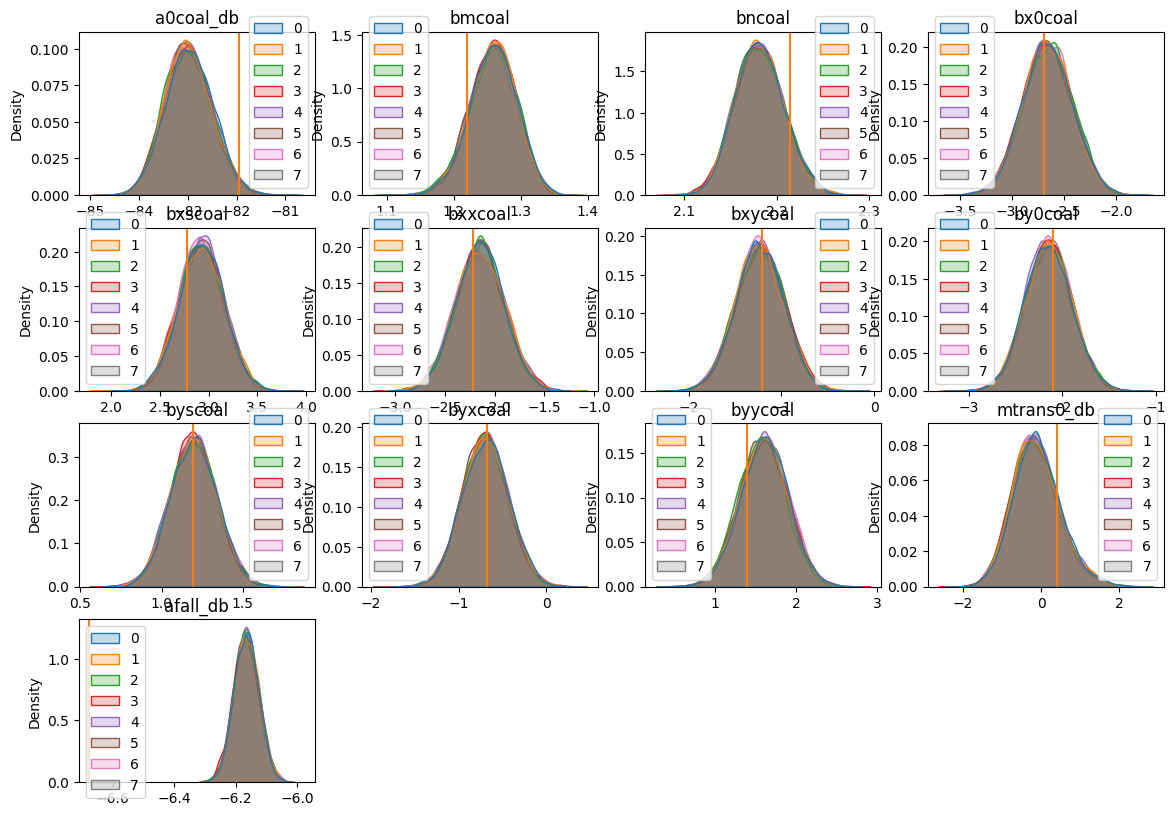

In [70]:
import matplotlib.gridspec as gridspec

# samples_origval = np.concatenate((samples_raw_vals, transformed_samples[:,:,-1:]), axis=2)
samples_origval = samples_raw_vals
# samples_origval = samples_with_ic[:,:,n_init:]

fig = plt.figure(figsize=(14,25))
gs = gridspec.GridSpec(10, 4)
for ipost in range(samples_origval.shape[-1]):
# for iparam, param_name in enumerate(param_names):
    param_name = param_names[ipost]
    ax = fig.add_subplot(gs[ipost])
    sns.kdeplot(samples_origval[:,:,ipost], fill=True)
    plt.axvline(param_mean[ipost], color='tab:orange')
    plt.title(param_name)
    # plt.plot((param_mean[iparam], param_mean[iparam]), ax.get_ylim(), color='tab:red')

# plt.show()


In [71]:
samples_origval.shape

(10000, 8, 13)

In [72]:
# sample_df = pd.DataFrame(samples_origval[:,0,:], columns=param_names)
# sns.pairplot(sample_df, kind='kde')

# validation

In [73]:
tsamples_combine_chains = transformed_samples[:,:,:-1].numpy().reshape(num_samples*nchains, npar)
meanresult = np.mean(tsamples_combine_chains, axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [IC_norm.shape[0], 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)
vars_after_MCMC_norm = cc_model(meanresults_incl_ics)


In [74]:
y_pred_inv = []
y_true_inv = []
y_pred = []
y_true = []

# for i in range(nvar):
#     y_pred_inv.append(ef.inv_boxcox(standard_scales[i].inverse_transform(cc_model(meanresults_incl_ics)[i].numpy()), mean_lams[i]))
#     y_true_inv.append(ef.inv_boxcox(standard_scales[i].inverse_transform(tgt_data[i]), mean_lams[i]))
#     y_pred.append(cc_model(meanresults_incl_ics)[i].numpy().astype('float64'))
#     y_true.append(tgt_data[i].astype('float64'))

# for i in range(nvar):
#     y_pred_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(cc_model(meanresults_incl_ics)[i].numpy().astype('float64')), eff0s[i]))
#     y_true_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(tgt_data[i].astype('float64')), eff0s[i]))
#     y_pred.append(cc_model(meanresults_incl_ics)[i].numpy().astype('float64'))
#     y_true.append(tgt_data[i].astype('float64'))
    
for i in range(nvar):
    if type(cc_model(meanresults_incl_ics)) is dict:
        presence = cc_model(meanresults_incl_ics)['presence'][i].numpy()
        presence[presence<0.1] = 0.
        if 'V_M' in var_constraints[i]:
            y_pred_inv.append(presence * minmaxscales[i].inverse_transform(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64')))
            y_true_inv.append(minmaxscales[i].inverse_transform(tgt_data[i].astype('float64')))
        else:
            if transform_method == 'meanboxcox':
                y_pred_inv.append(presence * ef.inv_boxcox(standard_scales[i].inverse_transform(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64')), mean_lams[i]))
                y_true_inv.append(ef.inv_boxcox(standard_scales[i].inverse_transform(tgt_data[i].astype('float64')), mean_lams[i]))
            elif transform_method == 'standard_scaler_asinh':
                y_pred_inv.append(presence * ef.inv_smooth_linlog(standard_scales[i].inverse_transform(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64')), eff0s[i]))
                y_true_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(tgt_data[i].astype('float64')), eff0s[i]))
            elif transform_method == 'minmaxscale_asinh':
                y_pred_inv.append(presence * ef.inv_smooth_linlog(minmaxscales[i].inverse_transform(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64')), eff0s[i]))
                y_true_inv.append(ef.inv_smooth_linlog(minmaxscales[i].inverse_transform(tgt_data[i].astype('float64')), eff0s[i]))

        y_pred.append(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64'))
    else:
        y_pred_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(cc_model(meanresults_incl_ics)[i].numpy().astype('float64')), eff0s[i]))
        y_true_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(tgt_data[i].astype('float64')), eff0s[i]))
        y_pred.append(cc_model(meanresults_incl_ics)[i].numpy().astype('float64'))
    y_pred.append(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64'))
    y_true.append(tgt_data[i].astype('float64'))

# for i in range(nvar):
#     presence = cc_model(meanresults_incl_ics)['presence'][i].numpy()
#     presence[presence<0.1] = 0.
#     if 'V_M' in var_constraints[idx]:
#         y_pred_inv.append(presence * minmaxscales[i].inverse_transform(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64')))
#         y_true_inv.append(minmaxscales[i].inverse_transform(tgt_data[i].astype('float64')))
#     else:
#         y_pred_inv.append(presence * ef.inv_smooth_linlog(standard_scales[i].inverse_transform(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64')), eff0s[i]))
#         y_true_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(tgt_data[i].astype('float64')), eff0s[i]))
#     y_pred.append(cc_model(meanresults_incl_ics)['water'][i].numpy().astype('float64'))
#     y_true.append(tgt_data[i].astype('float64'))

In [75]:
y_true_inv[0][y_true_inv[0]<1e-4] = np.nan

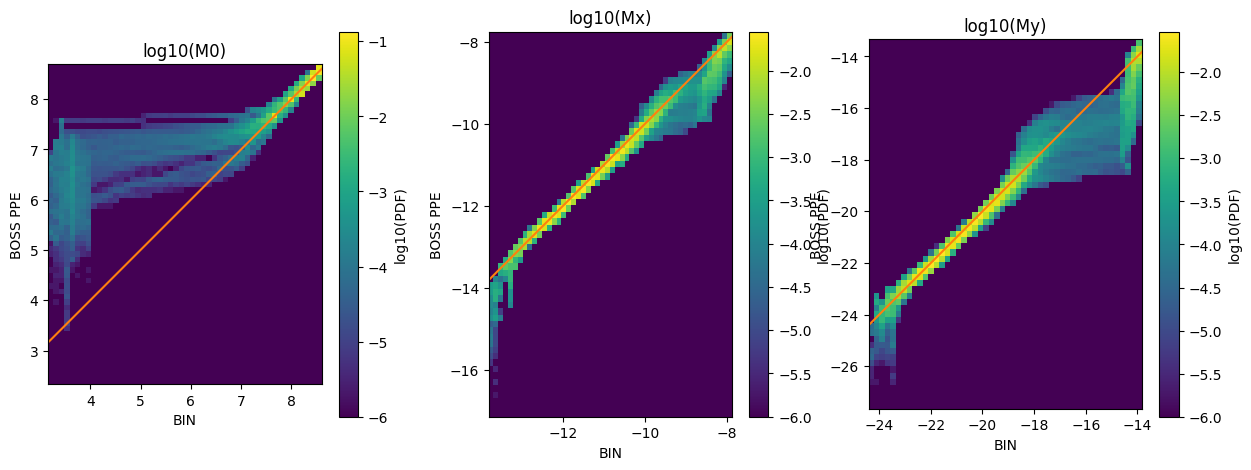

In [76]:
nrow = int(np.ceil(nvar/3))
fig = plt.figure(figsize=(15,5*nrow))
gs = gridspec.GridSpec(nrow,3)

idx=5

for i, (yt, yp) in enumerate(zip(y_true_inv, y_pred_inv)):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')

    # vpoint = np.logical_and(np.isfinite(yt), np.isfinite(yp))
    # hist, xedges, yedges = np.histogram2d(yt[vpoint], yp[vpoint], bins=[50, 60])

    vpoint = np.logical_and(yt>0., yp>0.)
    hist, xedges, yedges = np.histogram2d(np.log10(yt[vpoint]), np.log10(yp[vpoint]), bins=[50, 60])
    hist_min = 1e-6
    hist = hist/hist.sum()
    hist = np.log10(np.maximum(hist, hist_min)).T
    plt.pcolor(xedges, yedges, hist, cmap='viridis', shading='auto')
    plt.colorbar(label='log10(PDF)', ax=ax)

    # plt.scatter(yt, yp, alpha=0.01)
    ax = plt.gca()
    # if i==0:
    #     ax.set_xlim([1e-3, 1e8])
    #     ax.set_ylim([1e-3, 1e8])
    # ax.set_aspect('equal')
    # ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    # ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    ax_min = max([ax.get_ylim()[0]] + [ax.get_xlim()[0]])
    ax_max = min([ax.get_ylim()[1]] + [ax.get_xlim()[1]])
    plt.plot([ax_min, ax_max], [ax_min, ax_max], color='tab:orange')
    plt.xlabel('BIN')
    plt.ylabel('BOSS PPE')
    plt.title('log10(' + var_constraints[i] + ')')
    # if i>3:
    # plt.xscale('log')
    # plt.yscale('log')


In [77]:
fig.savefig('plots/MCMC_' + model_name + '.png')

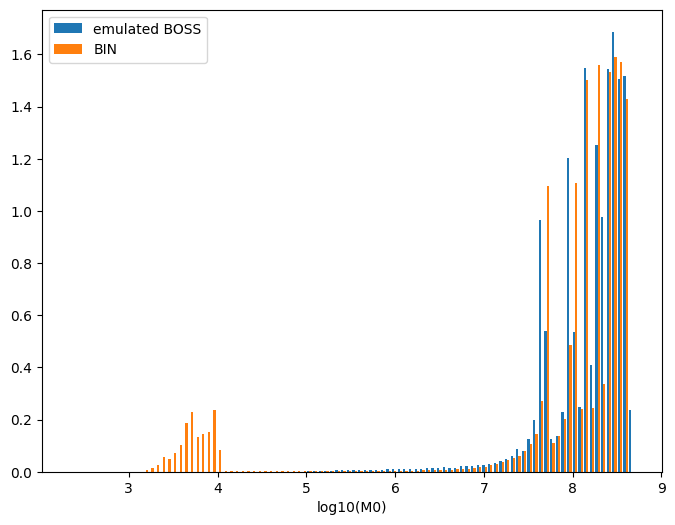

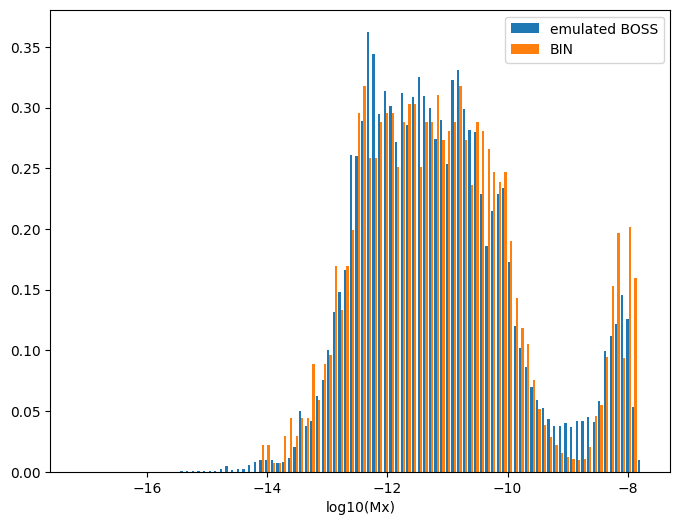

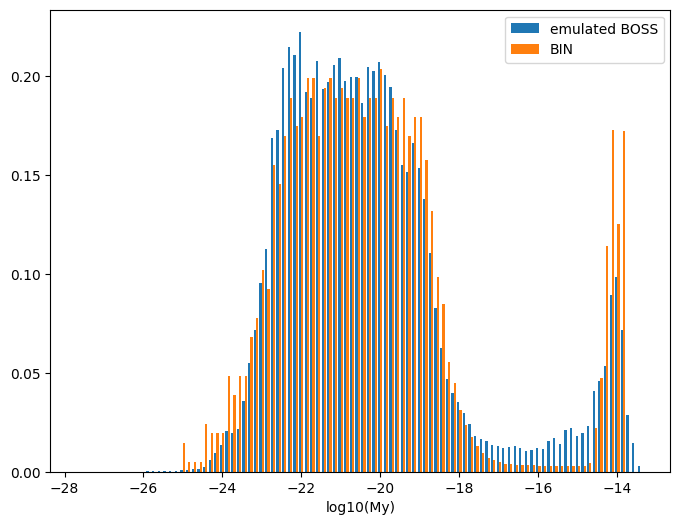

In [78]:
for i, eff0 in enumerate(eff0s):
    y_pred_inv[i][y_pred_inv[i]<=0] = np.nan
    y_true_inv[i][y_true_inv[i]<=0] = np.nan
    fig = plt.figure(figsize=(8, 6))
    _ = plt.hist([np.log10(y_pred_inv[i]).flatten(), np.log10(y_true_inv[i]).flatten()], 
                 bins=100, 
                 density=True,
                 label=['emulated BOSS', 'BIN'])
    plt.xlabel('log10(' + var_constraints[i] + ')')
    plt.legend()
    fig.savefig('plots/MCMC_' + model_name + '_' + var_constraints[i] + '.png')

# save posterior into netCDF

In [31]:
samples_raw_vals.shape, case_name

((10000, 8, 13), 'box_coal_qn_4map_hill_growth_ratio_46_momvals_N2000_dt1')

In [32]:
nbins = 50
count = {}
bins = {}
sample_sum_chains = samples_origval.reshape(num_samples*nchains,nparam)
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(sample_sum_chains[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

In [33]:
case_name

'box_coal_qn_4map_hill_growth_ratio_46_momvals_N2000_dt1'

In [34]:
import netCDF4 as nc
import numpy as np

# Create a new NetCDF file
ncfile = nc.Dataset('MCMC_posterior/' + case_name + '_post.nc', mode='w', format='NETCDF4')

# Create the dimension for parameters and bins
param_dim = ncfile.createDimension('nparam', len(param_names))
binmean_dim = ncfile.createDimension('nbin', nbins)
binedge_dim = ncfile.createDimension('nbinedge', nbins+1)

# Create variables
param_var = ncfile.createVariable('param_names', str, ('nparam',))
density_var = ncfile.createVariable('density', np.float32, ('nparam', 'nbin',))
bin_edges_var = ncfile.createVariable('bin_edges', np.float32, ('nparam', 'nbinedge',))
# sigma_dens_var = ncfile.createVariable('sigma_dens', np.float32, ('nbin',))
# sigma_edge_var = ncfile.createVariable('sigma_edge', np.float32, ('nbinedge',))

# Assign data
param_var[:] = np.array(param_names, dtype='S')
for i, pname in enumerate(param_names):
    # bins[pname] has nbins+1 edges, so we store the left edges for each bin
    density_var[i, :] = count[pname]
    bin_edges_var[i, :] = bins[pname]

# sigma_dens_var[:] = count['sigma'].astype('float32')
# sigma_edge_var[:] = bins['sigma']
ncfile.close()

In [35]:
# pd.DataFrame.from_dict(count).to_csv('MCMC_posterior/' + case_name + '_r0_param_density_narrow.csv', index=False)
# pd.DataFrame.from_dict(bins).to_csv('MCMC_posterior/' + case_name + '_r0_param_bins_narrow.csv', index=False)

In [27]:
model_name

'multioutput_box_coal_qn_hill_growth_ratio_46_momvals_target_BOSS_standard_scaler_asinh'

# update params csv

In [135]:
original_params = pd.read_csv(orig_param_csv + '.csv')
updated_params = original_params.copy()
for iparam, param_name in enumerate(param_names):
    binmean = (bins[param_name][1:] + bins[param_name][:-1])/2
    weighted_mean = np.average(binmean, weights=count[param_name])
    weighted_std = np.sqrt(np.cov(binmean, aweights=count[param_name], ddof=0))
    updated_params.loc[0, param_name] = weighted_mean
    updated_params.loc[2, param_name] = weighted_std

# coal_density = pd.read_csv('MCMC_posterior/coal_r2_param_density.csv')
# coal_param_names = coal_density.keys()[1:].to_list()
# coal_bin_edges = pd.read_csv('MCMC_posterior/coal_r2_param_bins.csv')

# for iparam, param_name in enumerate(coal_param_names):
#     binmean = (coal_bin_edges[param_name][1:].to_numpy() + coal_bin_edges[param_name][:-1].to_numpy())/2
#     weighted_mean = np.average(binmean, weights=coal_density[param_name])
#     updated_params.loc[0, param_name] = weighted_mean

updated_params.to_csv(orig_param_csv + '_updated_coal_4m_hill_growth_3046_ratio_momvals_r1.csv', index=False)

In [136]:
# np.std(binmean, weights=count[param_name])
updated_params

,Unnamed: 0,a0evap1_db,a0evap2_db,bm0evap1,bm0evap2,bx0evap1,bx0evap2,by0evap1,by0evap2,aevap_db,...,afall_db,bmfall,bx0fall,bx3fall,bxxfall,bxyfall,by0fall,by3fall,byxfall,byyfall
0,mean,38.610585,3.687102,-0.000563,-1.909830,1.576014,1.903903,-1.072642,-0.066690,-67.006062,...,-6.675757,0.571666,-0.146511,0.453007,0.038145,0.463250,0.451673,0.383639,-0.126374,0.775577
1,sd,0.190511,0.491666,0.000563,0.018053,0.027335,0.022666,0.036891,0.030800,0.013542,...,0.021235,0.001045,0.001771,0.002443,0.002072,0.002860,0.002301,0.005232,0.003649,0.005056
2,isd,32.997431,85.159046,0.097588,3.126787,4.734566,3.925938,6.389758,5.334682,2.345544,...,2.123531,0.104500,0.177060,0.244264,0.207151,0.285998,0.230120,0.523239,0.364868,0.505613
